In [2]:
import numpy as np
import math
from matplotlib import pyplot as plt
import random
import pandas as pd

The goal of this function is to implement Lewis' Thinning Algorithm -- generation of arrival events from an inhomogeneous Poisson Process. Suppose the time-varying rate is given by an intensity function $\lambda(t)$ which can be input into our function through an array of tumples Lambda = [(lambda1, t1), (lambda2, t2),...], representing the discrete values $\lambda(t_i)$ for intensity evluated at times $t_1,t_2,...$. T denotes the maximum time we consider for the Poinsson Process. 

In [3]:
pde_result=pd.read_excel(r'C:\Users\pc\Documents\school\Placental-Transmission-main\Placental-Transmission-main\result.xlsx')

In [46]:
pde=pd.read_csv(r'C:\Users\pc\Desktop\0.csv')

In [47]:
pde

,0,0.1,0.2,0.3
0,0.28,2.830000e-64,1.350000e-62,4.360000e-68
1,0.56,6.060000e-45,4.430000e-50,1.190000e-48
2,0.84,2.460000e-35,9.470000e-40,3.040000e-34
3,1.12,8.090000e-31,5.430000e-29,8.970000e-31
4,1.40,8.870000e-28,6.970000e-24,2.480000e-27
...,...,...,...,...
994,278.60,2.848900e-01,4.720300e+00,2.948900e+01
995,278.88,2.849900e-01,4.720100e+00,2.948900e+01
996,279.16,2.850900e-01,4.719900e+00,2.948900e+01
997,279.44,2.851900e-01,4.719600e+00,2.948900e+01


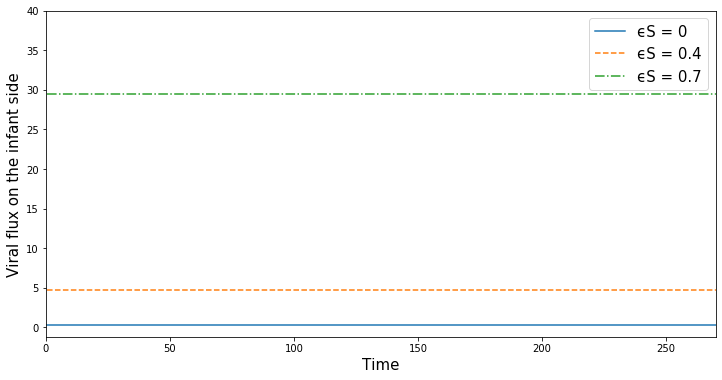

In [120]:
plt.figure(figsize=(12,6))
plt.plot(pde['0'],[2.852900e-01]*len(pde['0']) ,'-', label="ϵS = 0")
plt.plot(pde['0'],[4.719400e+00]*len(pde['0']),'--', label="ϵS = 0.4")
plt.plot(pde['0'],[2.948900e+01]*len(pde['0']),'-.', label="ϵS = 0.7")
#plt.yscale('symlog')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Viral flux on the infant side',fontsize=15)
plt.xlim(xmin=0,xmax=270)
plt.legend(fontsize=15,loc=1)
plt.rc('axes', labelsize=15)
plt.ylim(ymax=40)
plt.show()

In [146]:
# reshape toy data 
Lambda = list(zip(pde['0'],pde['0.1']))

In [147]:
def sample_from_exponential_dist(a):
    # random sampling from exponential distribution with mean a
    # we will use inverse sampling 
    u = random.random()
    x = (1/a) * math.log(1/(1-u))
    return x


In [148]:
def inhomogeneousPoisson(Lambda, T):
    '''
    First, we aim to generate an array arrival_times[] representing the arrival time from an homogeneous Poisson Process with 
    fixed rate lambda_max up to time T; meanwhile, we also generate samples from uniform distribution on [0,1] which will decide
    whether these arrival times from homogeneous Poisson Process will be accepted as sample of the inhomogeneous Poisson Process
    '''
    lambda_max = max(Lambda[i][1] for i in range(len(Lambda)))
    
    arrival_times = [0]
    unif_samples = []
    while arrival_times[-1] <= T:
        arrival_times.append(arrival_times[-1]+sample_from_exponential_dist(lambda_max))
        unif_samples.append(random.random())
        
    # take out the first dummy time 0 and the last time which exceeds maximum time T     
    arrival_times = arrival_times[1:-1]
    
    # check if we accept each arrival time in arrival_times[]
    accepted_arrival_times = []
    for i in range(len(arrival_times)):
        # find the rate lambda[t] at the proposed arrival time
        for j in range(len(Lambda)):
            if Lambda[j][0] > arrival_times[i]:
                break
        acceptance_probability = Lambda[j][1]/lambda_max
        if acceptance_probability > unif_samples[i]:
            accepted_arrival_times.append(arrival_times[i])
    
    return accepted_arrival_times

In [149]:
pde_result

,time,rate
0,0.000000,0.000000e+00
1,0.280280,3.002448e-71
2,0.560561,2.771159e-41
3,0.840841,1.082412e-37
4,1.121121,2.197778e-33
...,...,...
995,278.878879,1.546991e+00
996,279.159159,1.547087e+00
997,279.439439,1.547185e+00
998,279.719720,1.547285e+00


## Plot: Single Experiment

Red cross denotes the time when arrival happens. Blue curve is the given intensity function $\lambda(t)$

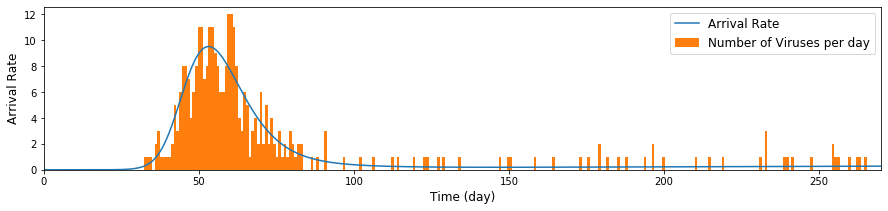

In [150]:
fig, ax = plt.subplots(figsize=(15,3))

ax.plot(pde['0'],pde['0.1'],label="Arrival Rate")
arrival_times = inhomogeneousPoisson(Lambda, 280)
#ax.scatter(arrival_times, [0.0001]*len(arrival_times), marker='X',c='r',label="Arrival time")
ax.hist(arrival_times, bins=280, label='Number of Viruses per day')
plt.xlabel("Time (day)",fontsize=12)
plt.ylabel("Arrival Rate",fontsize=12)
plt.legend(fontsize=12,loc=1)
plt.xlim(xmin=0,xmax=270)
plt.show()



In [151]:
arrival_times = inhomogeneousPoisson(Lambda, 280)

In [152]:
len(arrival_times)

299

In [153]:
class CMVsystem:

    def __init__(self, lam, mu, beta, alpha, delta,S0,p,c, S, L, I, V, ratio,virus_entry):
        self.lam = lam
        self.mu = mu
        self.beta = beta
        self.alpha = alpha
        self.delta=delta
        self.p = p
        self.c = c
        self.S0= S0
        self.t = 0.
        self.S = S
        self.L = L
        self.I = I
        self.V = V
        self.virus_entry=virus_entry
        self.ratio=ratio
        self.trajectory = np.array([[self.S, self.L, self.I,self.V]],dtype=float)
        self.times = None
            
#Define an initializer (__init__(self,beta,gamma,S,I,R)) which accepts model parameters beta and gamma, 
#and initial numbers of hosts in each of the S,I and R compartments.
    def reset(self, S, I, L, V,t=0.):
        self.t = t
        self.S = S
        self.L = L
        self.I = I
        self.V = V
        self.trajectory = np.array([[self.S, self.L, self.I, self.V]],dtype=float)

In [154]:
class StochasticCMVsystem (CMVsystem):

    """Define a specialized subclass of the general SIRsystem for modeling SIR dynamics as a stochastic, continuous
    time process, using the Gillespie method of continuous time Monte Carlo"""

    def step(self):
        """Implement one step of Gillespie's Direct Method based on current reaction rates: identify a reaction to fire
        next, as well as a time at which it will fire, and execute that reaction (similar to as was described in the
        StochasticCells exercise)."""
        
        #if no virus inside the system, wait till the first virus enters the system
        if self.V + self.I + self.L == 0:
            if self.virus_entry:
                self.t = virus_entry.pop()
                self.V = 1
            else:
                return None, self.t
        
            
        
        
        s = np.random.uniform(0,1)
        transition = None
        S_birth = self.lam
        S_death = self.mu*self.S
        inf_rate = self.beta*self.V*self.S/self.S0
        L_to_I = self.alpha*self.L
        #L_death = self.mu*self.L
        I_death = self.delta*self.I
        V_production = self.p*self.I
        V_death = self.c*self.V
        
        
        #S is kept constant
        #CASE1:with latent cells
        
        if s > self.ratio:
            rates=[inf_rate,L_to_I,I_death,V_production,V_death]
            total_rate=np.sum(rates)
            if total_rate == 0.:
                dt=0
            else:
                dt = np.random.exponential(1./total_rate, 1)[0]
            
            if self.virus_entry and self.t+dt > self.virus_entry[-1]:
                #print(self.t , self.virus_entry[-1])
                #recation does not happen, virus entry happens(case 1)
                self.V += 1
                self.t = self.virus_entry.pop()
                transition = 0
                
            else:
                #reaction happens
                if total_rate == 0.:
                    return transition, self.t
                if self.V+self.I+self.L == 0:
                    return transition, self.t
                if self.V+self.I+self.L == 1000:
                    return transition, self.t
                ranno = np.random.random()
                if ranno < np.sum(rates[0:1])/total_rate:
                    self.L += 1   #Latent cell production
                    transition = 1
                elif ranno < np.sum(rates[0:2])/total_rate:
                    self.I+=1     #Latent cell become infected
                    self.L-=1
                    transition = 2
                elif ranno < np.sum(rates[0:4])/total_rate:
                    self.I-=1      #Infected Cell death
                    transition = 3
                elif ranno < np.sum(rates[0:5])/total_rate:
                    self.V+=1      #virus creation
                    transition = 4
                elif ranno < np.sum(rates[0:6])/total_rate:
                    self.V-=1     #virus death
                    transition = 5
                    
                self.t += dt
                

        if s <= self.ratio:
            
            rates=[inf_rate,I_death,V_production,V_death]
            total_rate=np.sum(rates)
            if total_rate == 0.:
                dt=0
            else:
                dt = np.random.exponential(1./total_rate, 1)[0]
                

            if self.virus_entry and self.t+dt > self.virus_entry[-1]:
                #recation does not happen, virus entry happens
                self.V += 1
                self.t = self.virus_entry.pop()
                transition = 0
                
            else:
                #reaction happens

                if total_rate == 0.:
                    return transition, self.t
                if self.V + self.I==0:
                    return transition, self.t
                if self.V + self.I==1000:
                    return transition, self.t

                ranno = np.random.random()

                if ranno < np.sum(rates[0:1])/total_rate:
                    self.I += 1
                    transition = 1

                elif ranno < np.sum(rates[0:2])/total_rate:
                    self.I -= 1
                    transition = 2
                elif ranno < np.sum(rates[0:3])/total_rate:
                    self.V+=1
                    transition = 3
                elif ranno < np.sum(rates[0:4])/total_rate:
                    self.V-=1
                    transition = 4
                self.t += dt
                
                
                
        #dt = np.random.exponential(1./total_rate, 1)[0]
        #why 1/the hazard function? different from the textbook
        #print(transition, self.t)
        return transition, self.t

            
            
    def run(self, T = None, make_traj=True):
        """Run the Gillespie algorithm for stochastic simulation from time 0 to at least time T, starting with the initial
        values stored in the S,I,R state variables; story the result in self.trajectory if make_traj argument is
        set to True"""

        if T is None:
            T = sys.maxsize
        self.times = [0.]

        transition = 1
        while self.t < T:
            transition, t = self.step()
            if transition == None:
                return self.t
            if make_traj:
                self.trajectory = np.concatenate((self.trajectory, [[self.S,self.L,self.I,self.V]]), axis=0)
            self.times.append(self.t)
        return self.t

In [155]:
count=0;

In [164]:
for _ in range(100):
    virus_entry=arrival_times[::-1]

    mu=1/4.5; beta=0.0012; alpha=1; delta=0.77; S0=400;lam=mu*S0 ;p=1600;c=1.5; S=S0; L=0; I=0; V=0;ratio=0.5;
    M1 = StochasticCMVsystem(lam, mu, beta, alpha, delta, S0, p, c, S, L, I, V,ratio,virus_entry);

    M1.run(280)
    if M1.trajectory[-1,3]>1000:
        count+=1

    



In [165]:
count

0

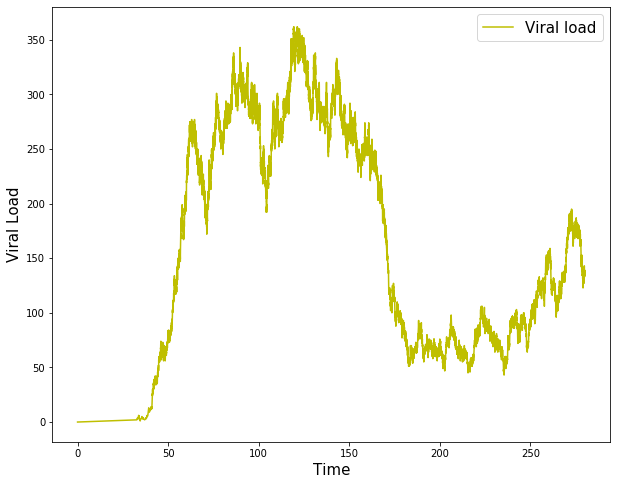

In [166]:
#plt.plot(M1.times[:-1], M1.trajectory[:-1,0], 'b-', label='S')
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(M1.times[:-1], M1.trajectory[:-1,3], 'y-', label='Viral load')

#plt.plot(M1.times[:-1], M1.trajectory[:-1,1], 'r-', label='Latent cells')
#plt.plot(M1.times[:-1], M1.trajectory[:-1,2], 'g-', label='Infected cells')
#plt.yscale("symlog")
plt.xlabel("Time",fontsize=15)
plt.ylabel("Viral Load",fontsize=15)
plt.legend(loc='upper right',fontsize=15)

Text(0, 0.5, 'Cell Count')

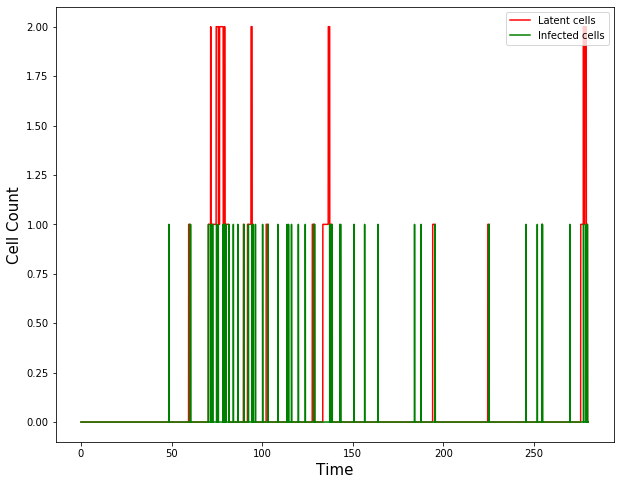

In [167]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(M1.times[:-1], M1.trajectory[:-1,1], 'r-', label='Latent cells')
plt.plot(M1.times[:-1], M1.trajectory[:-1,2], 'g-', label='Infected cells')
plt.xlabel('time',fontsize=15)
plt.ylabel('Cell count',fontsize=15)
plt.legend(loc='upper right')


#plt.yscale("symlog")
plt.xlabel("Time",fontsize=15)
plt.ylabel("Cell Count",fontsize=15)

Text(0, 0.5, 'Virus Count')

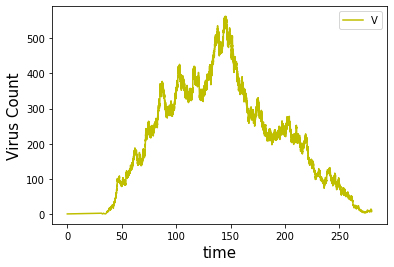

In [160]:
plt.plot(M1.times[:-1], M1.trajectory[:-1,3], 'y-', label='V')
plt.legend(loc='upper right')
plt.xlabel('time',fontsize=15)
plt.ylabel('Virus Count',fontsize=15)